## Welcome to Week 4, Single Cell RNA (cont.)!

### This week, we're going to go a bit deeper into scRNA analysis, such as how to interact with Seurat objects, add additional datatypes including CITE-seq and TCR/BCR-seq data, and create custom, publication-ready plots.

We'll continue to use Seurat, which has some nice capabilities for multi-modal data analysis. The two datatypes we will be working with today at **CITE-seq** and **TCR/BCR-seq** data. The main idea of both is that additional information about the cell is captured using the same cell barcode from reverse transcription so that multiple types of data can be assigned to the same cell. CITE-seq is a method for capturing surface protein information using oligo-conjugated antibodies developed at the New York Genome Center. Here antibodies are conjugated to oligos which contain two important sequences: an antibody specific barcode which is used to quantify surface protein levels in individual cells and a capture sequence (either poly-A sequence or a 10X specific capture sequence) which enables the antibody oligo to be tagged with the cell barcode during reverse transcription. You can look at more details in the publication here:  
* https://www.ncbi.nlm.nih.gov/pubmed/28759029  

Oligo-conjugated anitbodies compatible with 10X scRNA (both 5' and 3') are commercially available from BioLegend (https://www.biolegend.com/en-us/totalseq) and can also be used to multiplex different samples in the same 10X capture. This works by using an antibody which recognizes a common surface antigen and using the antibody barcode to distinguish between samples, a process known as **cell hashing**:
* https://www.ncbi.nlm.nih.gov/pubmed/30567574

We won't be using hashtag data today, but many of the same strategies apply and feel free to reach out if you are interested in learning more!  

The second data type we will be working with is TCR/BCR sequencing data. T and B cells express a highly diverse repertoire of transcripts resulting from V(D)J recombination - the T cell receptor (TCR) in T cells and immunoglobulin (Ig) or BCR in B cells. Daughter cells will share the same TCR/BCR sequence, allowing this sequence to be used to track clonal cell populations over time and space, as well as infer lineage relationships. TCR/BCR sequences are amplified from the cDNA library in the 5' immune profiling 10X kit, allowing these sequences to be matched to the gene expression library from the same cell. For more details, see the 10X website:
* https://www.10xgenomics.com/products/vdj/  

For both of these applications, a more in-depth understanding of how data is stored within a Seurat object will be helpful. We'll loosely be following this multimodal vingette here https://satijalab.org/seurat/v3.1/multimodal_vignette.html. Let's get started!

## Part 1: CITE-seq Analysis
First, let's reload the R object from last week using the **readRDS** function.

In [2]:
# load required libraries

library(dplyr)
library(Seurat)
library(patchwork)
library(RColorBrewer)
library(gridExtra)
library(ggplot2)
library(cowplot)
library(tidyr)
library(ggpubr)

In [3]:
figpath <- '4_figures/'
dir.create(figpath)

Warning message in dir.create(figpath):
“'4_figures' already exists”

In [4]:
pbmc <- readRDS("scrna_data/9K_pbmc.rds")

In [5]:
# Now let's add in the CITE-seq data that we skipped over last week:

pbmc.data <- Read10X(data.dir = "filtered_feature_bc_matrix")

10X data contains more than one type and is being returned as a list containing matrices of each type.


In [6]:
# Since we did some filtering on our cells to remove doublets, let's subset the CITE data to only include these cells.
adt.data <- pbmc.data$`Antibody Capture`
adt.data <- adt.data[,colnames(adt.data) %in% colnames(pbmc)]
dim(adt.data)
dim(pbmc)

[1]   17 6743

[1] 17961  6743

In [7]:
# which ADT features do we have?
rownames(adt.data)

[1] "CD3_TotalSeqC"           "CD19_TotalSeqC"         
 [3] "CD45RA_TotalSeqC"        "CD4_TotalSeqC"          
 [5] "CD8a_TotalSeqC"          "CD14_TotalSeqC"         
 [7] "CD16_TotalSeqC"          "CD56_TotalSeqC"         
 [9] "CD25_TotalSeqC"          "CD45RO_TotalSeqC"       
[11] "PD-1_TotalSeqC"          "TIGIT_TotalSeqC"        
[13] "IgG1_control_TotalSeqC"  "IgG2a_control_TotalSeqC"
[15] "IgG2b_control_TotalSeqC" "CD127_TotalSeqC"        
[17] "CD15_TotalSeqC"

In [8]:
# I think these names are too long. Let's remove -TotalSeqC from the end using gsub:
rownames(adt.data) <- gsub("_TotalSeqC", "", rownames(adt.data))
rownames(adt.data)

[1] "CD3"           "CD19"          "CD45RA"        "CD4"          
 [5] "CD8a"          "CD14"          "CD16"          "CD56"         
 [9] "CD25"          "CD45RO"        "PD-1"          "TIGIT"        
[13] "IgG1_control"  "IgG2a_control" "IgG2b_control" "CD127"        
[17] "CD15"

In [9]:
# We add the CITE-seq data, or antibody-derived tags (ADT) to a seperate "slot" in our R object.
# Note the difference from when we created a Seurat object from scratch using the RNA count data.

pbmc[["ADT"]] <- CreateAssayObject(counts = adt.data)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”

Our Seurat object now has two **assays** - RNA and ADT, which are stored in different slots. Seurat objects are a version of an S3 object in R. See more details here: https://github.com/satijalab/seurat/wiki/Seurat  

Here are some common ways of interacting with Seurat/S3 objects that will be useful. An important thing to consider now is which assay we are using by default, or the active assay (RNA or ADT for us).

In [10]:
# object summary:
pbmc

An object of class Seurat 
17978 features across 6743 samples within 2 assays 
Active assay: RNA (17961 features)
 1 other assay present: ADT
 2 dimensional reductions calculated: pca, umap

In [11]:
# how many RNA features and cells (since RNA is our default)
dim(pbmc)

[1] 17961  6743

In [12]:
# how many ADT features and cells (accessed throught the ADT slot)
# we can access this two ways
dim(pbmc@assays$ADT)
dim(pbmc[["ADT"]])

[1]   17 6743

[1]   17 6743

In [13]:
# which assay types are stored in our object?
names(pbmc)

[1] "RNA"     "ADT"     "RNA_nn"  "RNA_snn" "pca"     "umap"

In [14]:
# Let's process our ADT data according to the multimodal analysis vignette.
# Note that we specify the ADT assay when we run NormalizeData and ScaleData

pbmc <- NormalizeData(pbmc, assay = "ADT", normalization.method = "CLR")
pbmc <- ScaleData(pbmc, assay = "ADT")

Normalizing across features
Centering and scaling data matrix


Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”

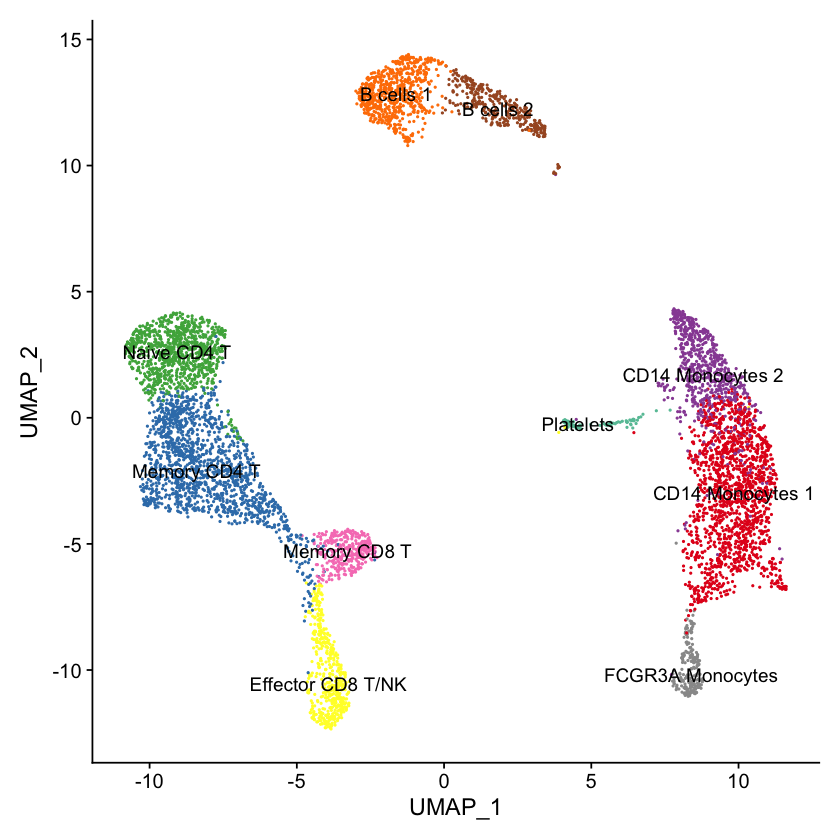

In [15]:
# Quickly let's refresh our memory on which clusters are which. Let's also add a custom color palette.
# It's ok if your clusters/UMAP are a little different! 

IdentColors <- c(brewer.pal(n = 9, name = "Set1"), brewer.pal(n = 8, name = "Set2"))
names(IdentColors) <- levels(Idents(pbmc))

DimPlot(pbmc, reduction = "umap", label = TRUE
        , cols = IdentColors[levels(Idents(pbmc))]) + NoLegend()

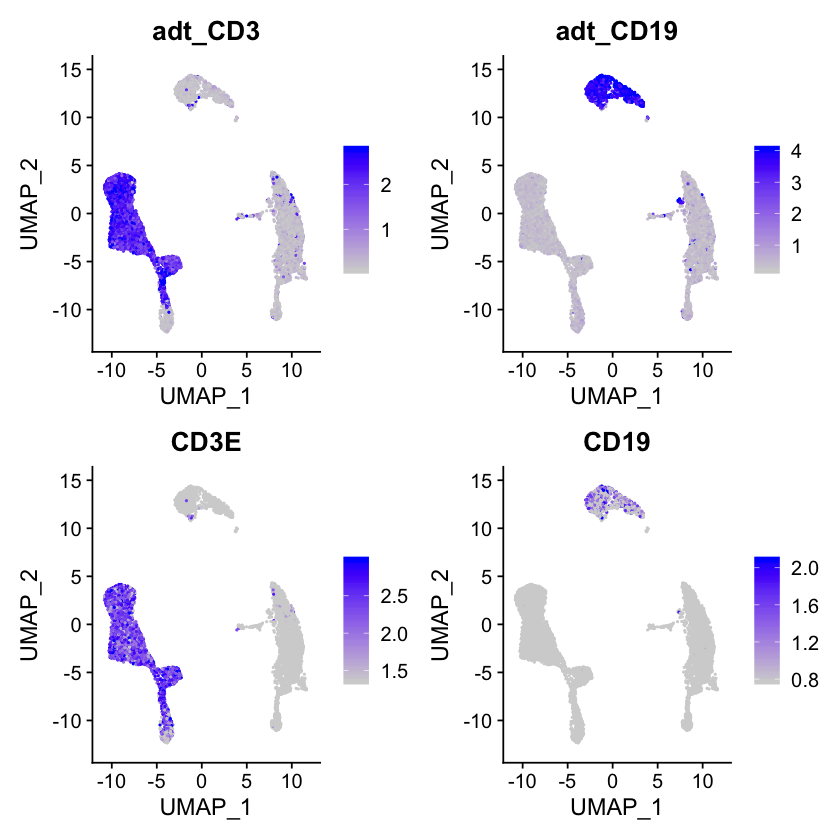

In [16]:
# Now let's compare RNA to ADT data on our UMAP from last week:
# in this plot, protein (ADT) levels are on top, and RNA levels are on the bottom
FeaturePlot(pbmc, features = c("adt_CD3", "adt_CD19", "CD3E", "CD19")
            , min.cutoff = "q05", max.cutoff = "q95", ncol = 2)

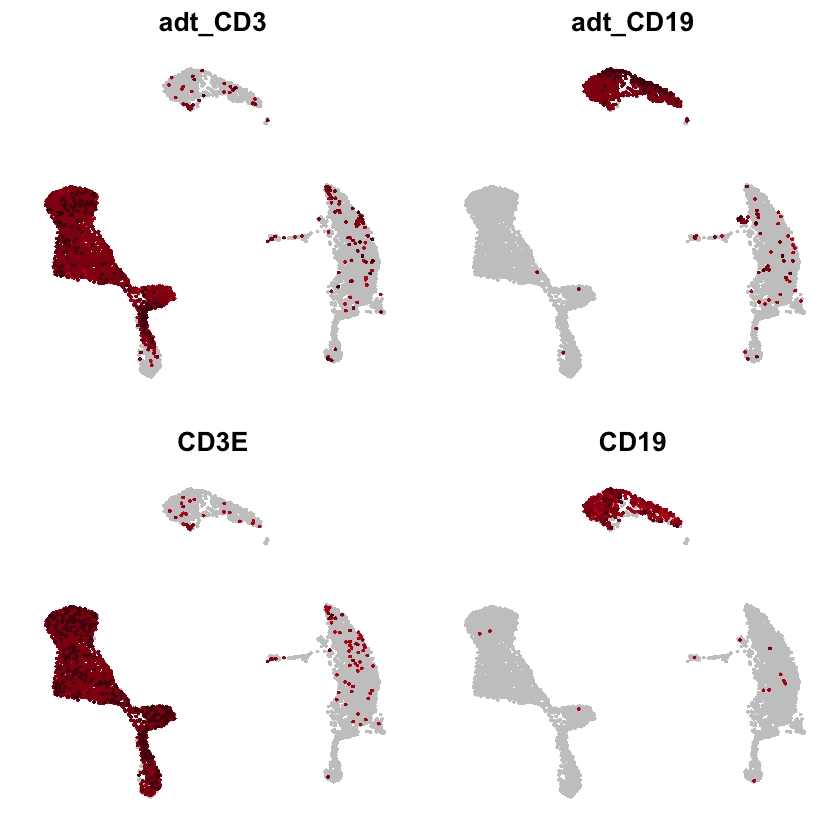

In [17]:
# Now we'll do a bit to make this figure look a little nicer.
# I personally like a red color scale and to leave off the UMAP coordinates and scale bar when plotting a lot.
# We can also "flatten" the plots so they don't lag in illustrator.
# To give ourselves more control, let's return the FeaturePlot as a list.
# Feel free to play with other parameters!

plot_list <- FeaturePlot(pbmc, combine = FALSE, pt.size = 1
            , features = c("adt_CD3", "adt_CD19", "CD3E", "CD19") #features to plot
            , cols = c("lightgrey", brewer.pal(n = 9, name = "Reds")[7:9]) #colors to use
            , sort.cell = TRUE) #put positive cells on top of plot

plot_list <- lapply(X = plot_list, FUN = AugmentPlot, width = 5, height = 5, dpi = 500) #flatten cells

for (i in 1:length(plot_list)) {
    plot_list[[i]] <- plot_list[[i]] + NoAxes() #remove axes and combine plots
}

grid.arrange(grobs = plot_list, ncol = 2)

In [ ]:
# Let's make a larger plot comparing all our ADT antibodies with their RNA expression. 
# Note that some protein names and RNA names differ, like PD-1 (gene name is PDCD1).
# Also CD45RO and CD45RA are different protein isoforms of CD45 so they will correspond to the same gene.
# Make sure it is organized nicely and rename the plot labels if you want.
# In the end save as a PDF and try opening in illustrator.

# see 4_ADTvRNA_UMAP.pdf for example output

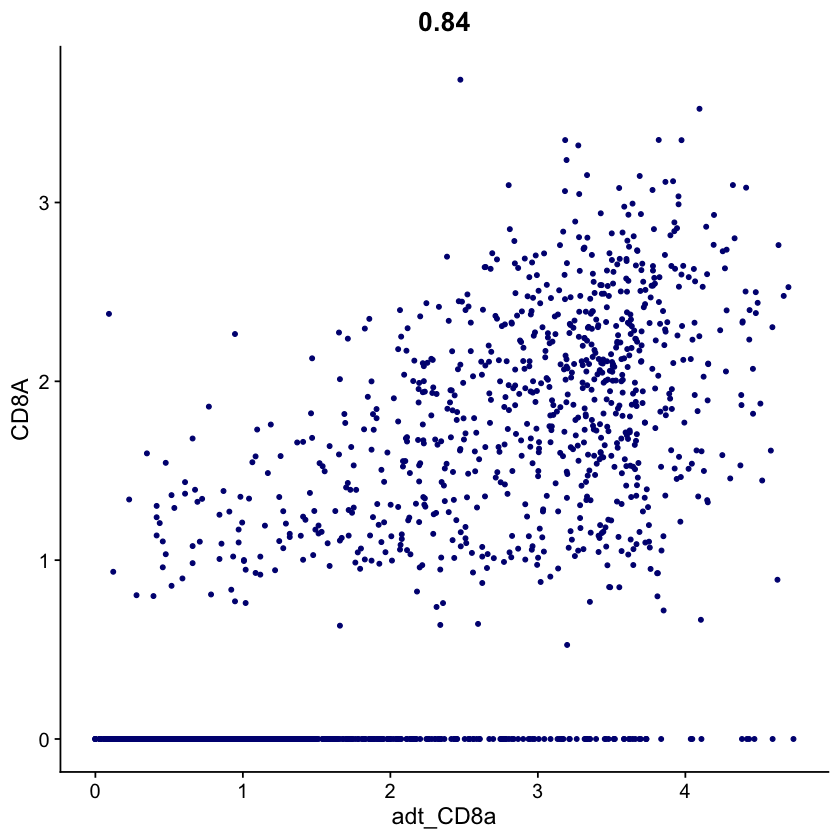

In [18]:
# Now let's compare how RNA compares to ADT for a few markers.
# I'll show an example, but then plot all markers and arrange nicely in a PDF
# Where does protein correlate well with RNA? Where does protein provide different information?

# see 4_ADTvRNA_scatter.pdf for example output
FeatureScatter(pbmc, feature1 = "adt_CD8a", feature2 = "CD8A", group.by = "orig.ident"
                     , cols = "navy") + NoLegend()

In [19]:
# Let's find protein markers for all clusters, and draw a heatmap
# But let's make it pretty 

#Reorder pbmc factors based on cell type similarity
Idents(pbmc) <- factor(Idents(pbmc), levels = c('Naive CD4 T', 'Memory CD4 T', 'Memory CD8 T', 'Effector CD8 T/NK'
                                               ,'B cells 1', 'B cells 2', 'CD14 Monocytes 1', 'CD14 Monocytes 2'
                                               , 'FCGR3A Monocytes', 'Platelets'))
adt.markers <- FindAllMarkers(pbmc, assay = "ADT", only.pos = TRUE)
adt.markers <- adt.markers %>% group_by(cluster) %>% top_n(20, avg_logFC)

# Let's use a constant number of cells for each cluster so small clusters aren't hard to see:
cells.use <- c()
for (i in unique(Idents(pbmc))) {
    cells.use <- c(cells.use, sample(Cells(pbmc)[Idents(pbmc) == i], size = min(table(Idents(pbmc)))))
}

p <- DoHeatmap(pbmc, features = unique(adt.markers$gene)[!grepl("IgG", unique(adt.markers$gene))], 
               , group.colors = IdentColors[levels(Idents(pbmc))]
               , cells = cells.use
               , assay = "ADT", angle = 45
               , size = 4
               , raster = FALSE
         ) + 
    scale_fill_gradientn(colours = rev(brewer.pal(n = 11, name = "RdBu")[1:9])) + 
    NoLegend()

pdf(paste0(figpath, '4_ADT_heatmap.pdf'), useDingbats = FALSE, width = 6, height = 6)
p
dev.off()

Calculating cluster Naive CD4 T
Calculating cluster Memory CD4 T
Calculating cluster Memory CD8 T
Calculating cluster Effector CD8 T/NK
Calculating cluster B cells 1
Calculating cluster B cells 2
Calculating cluster CD14 Monocytes 1
Calculating cluster CD14 Monocytes 2
Calculating cluster FCGR3A Monocytes
Calculating cluster Platelets
Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.


pdf 
  2

## Part 1: TCR/BCR-seq Analysis
First, we need to download the required data from these links:  
* https://support.10xgenomics.com/single-cell-vdj/datasets/3.0.0/vdj_v1_hs_pbmc2_t
* https://support.10xgenomics.com/single-cell-vdj/datasets/3.0.0/vdj_v1_hs_pbmc2_b

We'll need to download the **Clonotype info (CSV)** and **Filtered contig annotations (CSV)** files.

In [20]:
# Let's take a look at the TCR clonotypes first:
tcr_clonotypes <- read.csv("scrna_data/vdj_v1_hs_pbmc2_t_clonotypes.csv")
head(tcr_clonotypes)

,clonotype_id,frequency,proportion,cdr3s_aa,cdr3s_nt
,<fct>,<int>,<dbl>,<fct>,<fct>
1,clonotype1,22,0.006650544,TRA:CAVMDSNYQLIW;TRB:CASSDRGTGELFF,TRA:TGTGCTGTTATGGATAGCAACTATCAGTTAATCTGG;TRB:TGTGCCAGCAGTGACAGGGGCACCGGGGAGCTGTTTTTT
2,clonotype2,11,0.003325272,TRA:CALEGARLMF;TRB:CSAAWTVGTEAFF,TRA:TGTGCCCTGGAGGGTGCCAGACTCATGTTT;TRB:TGCAGTGCTGCCTGGACAGTCGGAACTGAAGCTTTCTTT
3,clonotype3,10,0.003022975,TRA:CVVKEGAGGGNKLTF;TRB:CASSQDGGGSNSPLHF,TRA:TGTGTGGTGAAGGAGGGGGCGGGAGGAGGAAACAAACTCACCTTT;TRB:TGCGCCAGCAGCCAAGATGGAGGGGGCTCTAATTCACCCCTCCACTTT
4,clonotype4,7,0.002116082,TRB:CASSDRGTGELFF,TRB:TGTGCCAGCAGTGACAGGGGCACCGGGGAGCTGTTTTTT
5,clonotype5,5,0.001511487,TRA:CAVNIGNTDKLIF;TRB:CSARGKPGLQETQYF,TRA:TGTGCCGTGAACATAGGCAACACCGACAAGCTCATCTTT;TRB:TGCAGTGCTAGAGGTAAACCGGGACTACAAGAGACCCAGTACTTC
6,clonotype9,4,0.001209190,TRA:CAVMDSNYQLIW,TRA:TGTGCTGTGATGGATAGCAACTATCAGTTAATCTGG


The clonotypes file summarizes the TCR clonotypes (unique TCR sequences) detected in our data. It groups them by **clonotype_id** (an arbitrarily numbered group) and also provides the CDR3 amino acid (**cdr3s_aa**) and nucleotide (**cdr3s_nt**) sequences for both the alpha (TRA) and beta (TRB) chains of the TCR. *But*, this file does not have any cell barcode information we can use to match with our scRNA data! Let's look at the filtered contig annotation file next.

In [21]:
tcr_contigs <- read.csv("scrna_data/vdj_v1_hs_pbmc2_t_filtered_contig_annotations.csv")
head(tcr_contigs)

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<fct>
1,AAACCTGAGACCACGA-1,True,AAACCTGAGACCACGA-1_contig_1,True,521,TRA,TRAV1-2,None,TRAJ12,TRAC,True,True,CAVMDSSYKLIF,TGTGCTGTGATGGATAGCAGCTATAAATTGATCTTC,1569,2,clonotype16,clonotype16_consensus_1
2,AAACCTGAGACCACGA-1,True,AAACCTGAGACCACGA-1_contig_3,True,584,TRB,TRBV6-1,TRBD2,TRBJ2-1,TRBC2,True,True,CASSGLAGGYNEQFF,TGTGCCAGCAGTGGACTAGCGGGGGGCTACAATGAGCAGTTCTTC,5238,7,clonotype16,clonotype16_consensus_2
3,AAACCTGAGGCTCTTA-1,True,AAACCTGAGGCTCTTA-1_contig_1,True,551,TRB,TRBV6-4,TRBD2,TRBJ2-3,TRBC2,True,True,CASSGVAGGTDTQYF,TGTGCCAGCAGTGGGGTAGCGGGAGGCACAGATACGCAGTATTTT,3846,4,clonotype26,clonotype26_consensus_2
4,AAACCTGAGGCTCTTA-1,True,AAACCTGAGGCTCTTA-1_contig_2,True,518,TRA,TRAV1-2,None,TRAJ33,TRAC,True,True,CAVKDSNYQLIW,TGTGCTGTGAAGGATAGCAACTATCAGTTAATCTGG,2019,2,clonotype26,clonotype26_consensus_1
5,AAACCTGAGTGAACGC-1,True,AAACCTGAGTGAACGC-1_contig_1,True,674,TRB,TRBV2,TRBD1,TRBJ1-2,TRBC1,True,True,CASNQGLNYGYTF,TGTGCCAGCAATCAGGGCCTTAACTATGGCTACACCTTC,3002,6,clonotype81,clonotype81_consensus_2
6,AAACCTGAGTGAACGC-1,True,AAACCTGAGTGAACGC-1_contig_2,True,504,TRA,TRAV1-2,None,TRAJ35,TRAC,True,True,CAVCTI,TGTGCTGTCTGTACGATA,2665,2,clonotype81,clonotype81_consensus_1


This file contains a lot of information, but the most important for us is the link between the cell barcode (**barcode**) and the clonotype (**raw_clonotype_id**). Subset this dataframe to just include these columns and remove duplicate barcodes. Check that each cell barcode is assigned to only one clonotype.

Now let's merge tcr_contigs with the clonotype information to annotate each cell with its TCR information:

Finally, let's add the TCR information as metadata to our seurat object. Note that the cell names in our seurat object do no have the "-1" suffix for the cell names, so lets remove that using gsub. The rownames of our matrix also need to be the cell names for the **AddMetaData** function.

Great! Let's write a function **add_clonotype** to do all of this for us. Our function should take as arguments: `seurat_object`, `clonotypes_path`, `contigs_path`, `lib_type` (tcr or bcr). Use this function to add the BCR data to our R object.

In [23]:
add_clonotype <- function(seurat_object, clonotypes_path, contigs_path, lib_type) {
 #Add your code here!
}

How many cells were matched with a TCR sequence? How many with a BCR sequence? How many with both? Which scRNA clusters have the most cells matched with TCR/BCR sequences?

Let's color our UMAP by which cells were annotated with either a TCR or BCR sequence (Hint: use the `cells.highlight` argument to `DimPlot`.

In [26]:
# see 4_TCR_BCR_UMAP.pdf for example output

Now make a stacked bar plot showing how many cells in each cluster were annotated with a TCR sequence, BCR sequence, or both (Hint: use the **FetchData** function and the **group_by** or **table** functions).

In [27]:
# see 4_TCR_BCR_barplot.pdf for example output

How big is the biggest TCR clone? What about the biggest BCR clone? Do all cells in the clone belong to the same cluster?

Let's make another stacked bar plot, this time plotting the clusters for cells belonging to the clones with at least 3 cells. What phenotypes are expanded clones enriched in? Do cells in the same clone often share the same phenotype or have different phenotypes?

In [28]:
# see 4_TCR_clone_barplot.pdf for example output

Finally, let's use gene signature scoring to see if there are any differences in T cell activation signature between our T cell phenotypes. Download the GSEA T_CELL_ACTIVATION gene set from here: https://www.gsea-msigdb.org/gsea/msigdb/cards/T_CELL_ACTIVATION in text file format. Use the **AddModuleScore** function to score cells for this signature and then plot the distribution of gene scores seperated by phenotype for all T cells assigned to a TCR clone. Use the **ggpubr** package to add p-values to your plot to see if the T cell activation signature is higher than naive T cells.

In [29]:
# see 4_TcellActivation_violinplot.pdf for example output